# 16-1. 데이터셋을 어디에서 구할까?

### MPII 데이터셋 다운로드하기
---
오늘은 MPII Human Pose Datasset을 사용해서 Human Pose Estimation task를 위한 모델을 훈련시켜 보겠습니다.

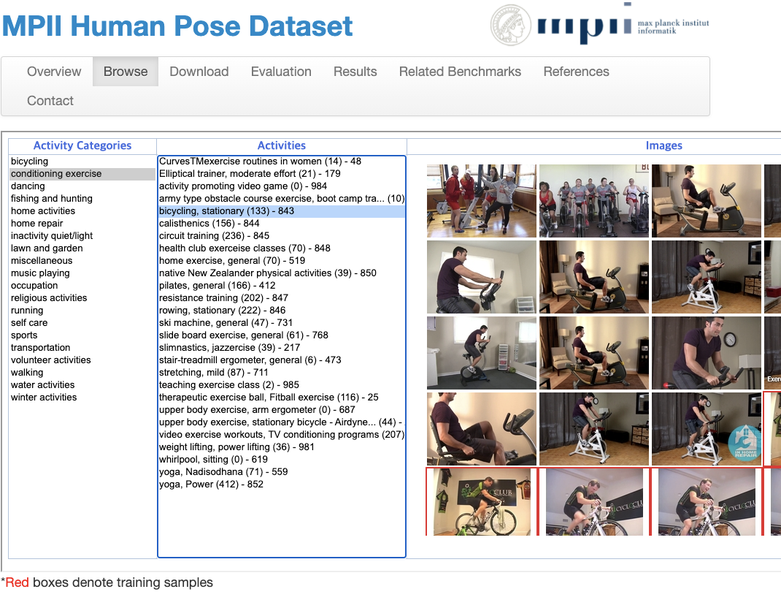

> mpii_human_pose_v1.tar.gz 파일은 무려 12GB가 넘는 용량을 가지고 있습니다.
>
> 아래 명령어를 통해 클라우드에 미리 다운되어 있는 데이터를 링크를 걸어서 압축을 해제하여 실습을 진행 부탁드립니다.

In [1]:
!mkdir -p ~/aiffel/mpii
!ln -s ~/data/* ~/aiffel/mpii
!cd ~/aiffel/mpii

!tar -xvf mpii_human_pose_v1.tar.gz -C . #압축 해제 부분
!unzip mpii_human_pose_v1_u12_2.zip

tar: mpii_human_pose_v1.tar.gz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
unzip:  cannot find or open mpii_human_pose_v1_u12_2.zip, mpii_human_pose_v1_u12_2.zip.zip or mpii_human_pose_v1_u12_2.zip.ZIP.


mpii_human_pose_v1_u12_2.zip 을 풀어보면 mpii_human_pose_v1_u12_1.mat 파일이 나와서 열어보기 불편한데요.

파이썬에서 읽기 쉽도록 json 파일로 변환해 두었습니다.

In [2]:
!cd ~/aiffel/mpii/mpii_human_pose_v1_u12_2
!wget https://d3s0tskafalll9.cloudfront.net/media/documents/train.json
!wget https://d3s0tskafalll9.cloudfront.net/media/documents/validation.json

/bin/bash: line 0: cd: /aiffel/aiffel/mpii/mpii_human_pose_v1_u12_2: No such file or directory
--2022-01-20 12:00:46--  https://d3s0tskafalll9.cloudfront.net/media/documents/train.json
Resolving d3s0tskafalll9.cloudfront.net (d3s0tskafalll9.cloudfront.net)... 99.84.170.113, 99.84.170.48, 99.84.170.144, ...
Connecting to d3s0tskafalll9.cloudfront.net (d3s0tskafalll9.cloudfront.net)|99.84.170.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31043010 (30M) [application/json]
Saving to: ‘train.json’

train.json          100%[===================>]  29.60M  11.6MB/s    in 2.6s    

2022-01-20 12:00:49 (11.6 MB/s) - ‘train.json’ saved [31043010/31043010]

--2022-01-20 12:00:50--  https://d3s0tskafalll9.cloudfront.net/media/documents/validation.json
Resolving d3s0tskafalll9.cloudfront.net (d3s0tskafalll9.cloudfront.net)... 99.84.170.173, 99.84.170.113, 99.84.170.144, ...
Connecting to d3s0tskafalll9.cloudfront.net (d3s0tskafalll9.cloudfront.net)|99.84.170.173|:443.

마지막으로, 오늘의 실습 코드를 프로젝트로 구성한 파일을 첨부합니다.

위의 `mpii.zip`을 압축을 해제 후 `cloud jupyter` 에 `/aiffel/mpii` 경로에서 확인해 보실 수 있습니다.

In [3]:
!cd ~/aiffel/mpii && unzip mpii.zip

Archive:  mpii.zip
  inflating: hourglass104.py         
   creating: models/
  inflating: preprocess.py           
  inflating: simplebaseline.py       
  inflating: test.ipynb              
  inflating: test.py                 
  inflating: tfrecords_mpii.py       
  inflating: train.py                
  inflating: Untitled.ipynb          


# 16-2. 데이터 전처리하기

필요한 패키지를 확인합니다.

In [4]:
!pip list | grep loguru
!pip list | grep ray

loguru                        0.5.3
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
ray                           1.1.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


저는 `tfrecords_mpii.py` 라는 이름으로 파일을 생성해서, 이후 데이터 전처리 과정을 거쳐 tfrecord 파일을 생성하는 작업을 진행하겠습니다.

이 파일은 이전 스텝에 다운로드한 `mpii.zip` 에도 포함되어 있으므로 함께 확인해 주세요.

In [5]:
import csv
import io
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '-1' #CPU 사용
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

workdir = os.path.join(os.getenv('HOME'),'aiffel/mpii')
os.chdir(workdir)

from loguru import logger
from PIL import Image
import ray
import tensorflow as tf

num_train_shards = 64
num_val_shards = 8
ray.init()
tf.get_logger().setLevel('ERROR')

2022-01-20 12:02:32,778	WARNING utils.py:480 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-01-20 12:02:33,351	INFO services.py:1173 -- View the Ray dashboard at http://127.0.0.1:8265
2022-01-20 12:02:33,357	WARNING services.py:1640 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This may slow down performance! You may be able to free up space by deleting files in /dev/shm or terminating any running plasma_store_server processes. If you are inside a Docker container, you may need to pass an argument with the flag '--shm-size' to 'docker run'.


### json 파싱하기
---
이전 스텝에서 train.json과 validation.json 파일을 다운로드받은 것을 기억하시나요?

이 파일들은 이미지에 담겨 있는 사람들의 pose keypoint 정보들을 가지고 있어서 Pose Estimation을 위한 label로 삼을 수 있습니다.

우선 json이 어떻게 구성되어 있는지 파악해 보기 위해 json 파일을 열어 샘플로 annotation 정보를 1개만 출력해 봅시다.

json.dumps()를 활용해서 좀 더 명확하게 하면 더욱 좋습니다.

In [7]:
import json, os

json_file_path = os.getenv('HOME')+'/aiffel/mpii/mpii_human_pose_v1_u12_2/train.json'

with open(json_file_path) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2) # json beautify
    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


`joints` 가 우리가 label 로 사용할 keypoint 의 label 입니다.

이미지 형상과 사람의 포즈에 따라 모든 label 이 이미지에 나타나지 않기 때문에 `joints_vis` 를 이용해서 실제로 사용할 수 있는 keypoint 인지 나타냅니다.

MPII 의 경우 1 (visible) / 0(non) 으로만 나누어지기 때문에 조금 더 쉽게 사용할 수 있습니다.

coco 의 경우 2 / 1 / 0 으로 표현해서 occlusion 상황까지 label 화 되어 있습니다.

`joints` 순서는 아래와 같은 순서로 배치되어 저장해 뒀습니다.

- 0 - 오른쪽 발목
- 1 - 오른쪽 무릎
- 2 - 오른쪽 엉덩이
- 3 - 왼쪽 엉덩이
- 4 - 왼쪽 무릎
- 5 - 왼쪽 발목
- 6 - 골반
- 7 - 가슴(흉부)
- 8 - 목
- 9 - 머리 위
- 10 - 오른쪽 손목
- 11 - 오른쪽 팔꿈치
- 12 - 오른쪽 어깨
- 13 - 왼쪽 어깨
- 14 - 왼쪽 팔꿈치
- 15 - 왼쪽 손목

index 값은 여러분도 언제든지 바꿔서 사용할 수 있습니다.

가장 어렵게 느껴지는 값은 `scale` 과 `center` 일 것 같습니다.

- 높이 = scale * 200px
- center 는 사람의 중심점입니다.

200px 이 왜 상숫값으로 고정되어 있을까요? 꽤 많이 찾아봤지만 정확한 근거는 없습니다... (단순히 매직넘버)

- https://github.com/bearpaw/pytorch-pose/issues/31

검색해 보면 위 링크와 같이 토론이 일어나지만 '사람 키를 200px 로 가정한다' 수준의 정보만 있습니다.

적절한 근거가 없어서 어렵게 느껴지는 부분이지만 "편의상 사용한다" 정도로 이해하고 넘어가겠습니다. 특이한 점은 scale 정보가 coco dataset에는 scale 값 또한 2차원으로 주어져서 bbox scale 이 나오지만 mpii 는 높이만 나온다는 점입니다.

이제 json annotation 을 파싱하는 함수를 만들어 보겠습니다.

In [ ]:
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

image 의 전체 path 를 묶어 dict 타입의 label 로 만들어 냅니다. 이 label 을 가지고 학습을 진행하면 됩니다.

# 16-3. tfrecord 파일 만들기

### tfrecord 파일 만들기

이전까지는 tf.keras 의 `imagedatagenerator` 를 이용해서 주로 학습 데이터를 읽었습니다. 하지만 실제 프로젝트에서는 튜토리얼 데이터셋보다 훨씬 큰 크기의 데이터를 다뤄야 합니다.

학습을 많이 해볼수록 학습 속도에 관심을 가지게 되는데요. [tensorflow 튜토리얼 문서](https://www.tensorflow.org/tutorials/load_data/tfrecord?hl=en)에는 다음과 같은 표현으로 나타나 있습니다.

> unless you are using tf.data and reading data is still the bottleneck to training.

일반적으로 학습 과정에서 gpu 의 연산 속도보다 HDD I/O 가 느리기 때문에 병목 현상이 발생하고 대단위 프로젝트 실험에서 효율성이 떨어지는 것을 관찰할 수 있습니다. (답답해요..)

따라서 "학습 데이터를 어떻게 빠르게 읽는가?" 에 대한 고민을 반드시 수행하셔야 더 많은 실험을 할 수 있습니다.

다음 링크를 보고 퀴즈를 풀어 봅시다.

- [tf-guide/data_performance](https://www.tensorflow.org/guide/data_performance?hl=ko)

Q1. 학습 속도를 향상시키기 위해서 데이터 관점에서 고려해야하는 단계는 어떤 단계인가요? 속도 향상을 위한 처리 방법을 위 링크에서 찾아 대답해 봅시다.

A1. data read(또는 prefetch) 또는 데이터 변환 단계. gpu 학습과 병렬적으로 수행되도록 prefetch를 적용해야 함. 수행방법은 tf.data의 map 함수를 이용하고 cache 에 저장해두는 방법을 사용해야함.

내용이 꽤 어렵습니다만 tf 에서는 위 변환을 자동화해주는 도구를 제공합니다. 데이터셋을 tfrecord 형태로 표현하는 것인데요. tfrecord 는 binary record sequence 를 저장하기 위한 형식입니다.

내부적으로 protocol buffer 라는 것을 이용합니다.

- https://developers.google.com/protocol-buffers/?hl=ko

protobuf 는 크로스 플랫폼에서 사용할 수 있는 직렬화 데이터 라이브러리라고 생각하시면 됩니다. 데이터셋 크기가 크기 때문에 빠른 학습을 위해서 이 정보를 tfrecord 파일로 변환해 보겠습니다.

In [8]:
import ray

def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        # train_0001_of_0064.tfrecords
        build_single_tfrecord.remote(
            chunk, './tfrecords_mpii/{}_{}_of_{}.tfrecords'.format(
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

구현 내용을 보면 몇 가지 어려운 용어가 등장합니다. tfrecord 로 표현하기 위해 필요한데요. 먼저 해석해 보자면,

- annotation 을 total_shards 개수로 나눔(chunkify) (train : 64개, val : 8개)
- build_single_tfrecord 함수를 통해 tfrecord 로 저장
- 각 chunk 끼리 dependency 가 없기 때문에 병렬처리가 가능, ray를 사용

아래 링크를 보고 퀴즈를 풀어 봅시다.

[tf-tutorials/load_data/tfrecord](https://www.tensorflow.org/tutorials/load_data/tfrecord?hl=ko)

Q2. annotation 을 왜 shard 로 나눠야할까요? 위 링크를 참고해서 대답해 봅시다.

A2. I/O 병목을 피하기 위해 입력 파일을 여러개로 나눈 뒤, 병렬적으로 prefetch 하는 것이 학습 속도를 빠르게 합니다. 튜토리얼에서는 경험상 데이터를 읽는 호스트보다 최소 10 배 많은 파일을 보유하는 것이 좋습니다. 동시에 각 파일은 I / O 프리 페치의 이점을 누릴 수 있도록 충분히 커야합니다 (최소 10MB 이상, 이상적으로는 100MB 이상) 이라고 친절하게 사용 팁을 알려주고 있습니다.

tf 튜토리얼에서 알려준 대로 annotation 을 적절한 개수로 (저는 64개 정도로..) 나누는 함수를 작성합니다.

In [10]:
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n - 1):
        results.append(l[start:start + size])
        start += size
    results.append(l[start:])
    return results

- l 은 annotation, n은 shard 개수
- shard 개수 단위로 annotation list 를 나누어서 새로운 list를 만듭니다.
- numpy array 라고 가정하면 (size, shard, anno_content) 정도의 shape을 가지겠죠?

tfrecord 1개를 저장하는 함수를 만듭니다. 위에서 설명하지 않은 부분이 있는데요, ray 를 일단 무시하고 보셔도 흐름상 큰 관계는 없습니다.

In [11]:
@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno_list in chunk:
            tf_example = genreate_tfexample(anno_list)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

- TFRecordWriter 를 이용해서 anno_list 를 shard 개수 단위로 작성합니다.
- generate_tfexample 함수를 사용합니다. → 아래에서 자세히 설명하겠습니다.
- 중요 write 할 때 string 으로 serialize 해야 합니다.

tfrecord 는 직렬화된 데이터를 저장하는 표현 방법, 라이브러리이기 때문에 규칙을 따라줘야 합니다.

- [직렬화에 대한 discussion](https://www.inflearn.com/questions/67208)

tf.example 은 아래와 같이 만들 수 있습니다.

In [12]:
def generate_tfexample(anno):
    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    # 0 - invisible, 1 - occluded, 2 - visible
    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

- 우리가 정의한 json 의 python type의 값들을 tfexample 에 사용할 수 있는 값으로 변환합니다.
- image 파일은 byte 로 변환합니다. bitmap 으로 저장하게 되면 파일 용량이 상당히 커지기 때문에 만약 jpeg 타입이 아닌 경우 jpeg 으로 변환 후 content 로 불러서 저장합니다. (H,W,C)
- 각 label 값을 tf.train.Feature 로 저장합니다. 이때 데이터 타입에 주의해야 합니다.
- 이미지는 byte 인코딩 된 값을 그대로 넣습니다.

In [13]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy(
        )  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# 16-4. Ray

Ray 는 파이썬을 위한 간단한 분산 애플리케이션 api 입니다. (multiprocessing 을 생각하시면 됩니다.)

- https://docs.ray.io/en/latest/

아래 링크를 참고해서 퀴즈를 풀어 봅시다.

- [10x Faster Parallel Python Without Python Multiprocessing](https://towardsdatascience.com/10x-faster-parallel-python-without-python-multiprocessing-e5017c93cce1)

Q3. multiprocessing 과 ray 의 사용상 차이점은 무엇인가요? 위 링크를 참고해서 대답해 봅시다.

A3. MP 는 병렬화를 위해 추상적 구조를 새로 설계해야 하지만 ray 는 쓰던 코드에서 거의 수정 없이 병렬화 할 수 있는 장점이 있습니다.

In [14]:
# tfrecords_mpii.py
import csv
import io
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from loguru import logger
from PIL import Image
import ray
import tensorflow as tf

num_train_shards = 64
num_val_shards = 8
ray.init()
tf.get_logger().setLevel('ERROR')


def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n - 1):
        results.append(l[start:start + size])
        start += size
    results.append(l[start:])
    return results


def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy(
        )  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def generate_tfexample(anno):
    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    # x = [
    #     joint[0] / width if joint[0] >= 0 else joint[0]
    #     for joint in anno['joints']
    # ]
    # y = [
    #     joint[1] / height if joint[1] >= 0 else joint[0]
    #     for joint in anno['joints']
    # ]
    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    # 0 - invisible, 1 - occluded, 2 - visible
    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        # 'image/object/parts/x':
        # tf.train.Feature(float_list=tf.train.FloatList(value=x)),
        # 'image/object/parts/y':
        # tf.train.Feature(float_list=tf.train.FloatList(value=y)),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))


@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno_list in chunk:
            tf_example = generate_tfexample(anno_list)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)


def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        # train_0001_of_0064.tfrecords
        build_single_tfrecord.remote(
            chunk, './tfrecords_mpii/{}_{}_of_{}.tfrecords'.format(
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)


def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation


def main():
    print('Start to parse annotations.')
    if not os.path.exists('./tfrecords_mpii'):
        os.makedirs('./tfrecords_mpii')

    with open('./mpii_human_pose_v1_u12_2/train.json') as train_json:
        train_annos = json.load(train_json)
        train_annotations = [
            parse_one_annotation(anno, './images/')
            for anno in train_annos
        ]
        print('First train annotation: ', train_annotations[0])
        del (train_annos)

    with open('./mpii_human_pose_v1_u12_2/validation.json') as val_json:
        val_annos = json.load(val_json)
        val_annotations = [
            parse_one_annotation(anno, './images/') for anno in val_annos
        ]
        print('First val annotation: ', val_annotations[0])
        del (val_annos)

    print('Start to build TF Records.')
    build_tf_records(train_annotations, num_train_shards, 'train')
    build_tf_records(val_annotations, num_val_shards, 'val')

    print('Successfully wrote {} annotations to TF Records.'.format(
        len(train_annotations) + len(val_annotations)))


if __name__ == '__main__':
    main()

RuntimeError: Maybe you called ray.init twice by accident? This error can be suppressed by passing in 'ignore_reinit_error=True' or by calling 'ray.shutdown()' prior to 'ray.init()'.

아래와 같이 tfrecord 생성을 터미널을 통해 수행해 봅시다. (수행 시간이 10분 이상 소요 됩니다.)

In [ ]:
!cd ~/aiffel/mpii && python tfrecords_mpii.py

아래 명령어를 실행해 보면

In [ ]:
!cd ~/aiffel/mpii/tfrecords_mpii && ls | wc

약 200MB 정도의 tfrecords들이 72개 만들어진 것을 알 수 있습니다.

# 16-5. data label 로 만들기

tfrecords 파일을 읽고 전처리를 할 수 있는 dataloader 를 만들겠습니다.

저는 `preprocess.py` 라는 이름으로 파일을 생성하겠습니다. 이 파일도 `mpii.zip`에 포함되어 있으므로 함께 확인해 주세요.

In [ ]:
import tensorflow as tf

class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y)

        # print (image.shape, heatmaps.shape, type(heatmaps))

        return image, heatmaps

위 `Preprocessor` 클래스 코드에서 `__call__()` 메소드 내부에서 진행되는 주요 과정을 정리하면 아래와 같습니다.

- tfrecord 파일이기 때문에 병렬로 읽는 것은 tf 가 지원해 주고 있습니다. `self.parse_tfexample()` 에 구현되어 있고 이 함수를 통해 `tf.tensor` 로 이루어진 dictionary 형태의 `features`를 얻을 수 있습니다.
- 즉 image 는 `features['image/encoded']` 형태로 사용할 수 있고 tfrecord 를 저장할 때 jpeg encoding 된 값을 넣었으므로 `tf.io.decode_jpeg()`로 decoding 하여 tensor 형태의 이미지를 얻습니다.
- `crop_roi()` 메소드를 이용해 해당 이미지를 학습하기 편하도록 몇 가지 트릭을 적용합니다. 구현은 아래에서 다시 소개하겠습니다.
- `make_heatmaps()` 메소드를 이용해 label을 heatmap 으로 나타냅니다.

In [ ]:
def parse_tfexample(self, example_proto):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'imaage/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example_proto,
                                          image_feature_description)b

tfrecord 파일 형식을 우리가 저장한 data type feature 에 맞게 parsing 합니다.

tf 가 자동으로 parsing 해주는 점은 아주 편하지만 feature description 을 정확하게 알고 있어야 하는 단점이 있습니다.

즉, tfrecord 에서 사용할 key 값들과 data type 을 모르면 tfrecord 파일을 사용하기 굉장히 어렵습니다. (serialize 되어있으므로..)

이렇게 얻은 image 와 label 을 이용해서 적절한 학습 형태로 변환합니다.

In [ ]:
def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        # keypoint 중 유효한값(visible = 1) 만 사용합니다.
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        # min, max 값을 찾습니다.
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        # 높이 값을 이용해서 x, y 위치를 재조정 합니다. 박스를 정사각형으로 사용하기 위해 아래와 같이 사용합니다.
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        # 이미지 크기를 벗어나는 점을 재조정 해줍니다.
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        # shift all keypoints based on the crop area
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y

우리가 알고 있는 것은 joints 의 위치, center 의 좌표, body height 값입니다.

균일하게 학습하기 위해 body width 를 적절히 정하는 것도 중요합니다.

저는 높이 정보와 keypoint 위치를 이용해서 정사각형 박스를 사용하는 것을 기본으로 디자인했습니다.

이와 관련해서는 여러 방법이 있을 수 있겠지만 배우는 단계에서 더 중요하게 봐야 할 부분은 우리가 임의로 조정한 crop box 가 이미지 바깥으로 나가지 않는지 예외 처리를 잘 해주어야 한다는 점입니다.

(x, y) 좌표로 되어있는 keypoint 를 heatmap 으로 변경시킵니다.

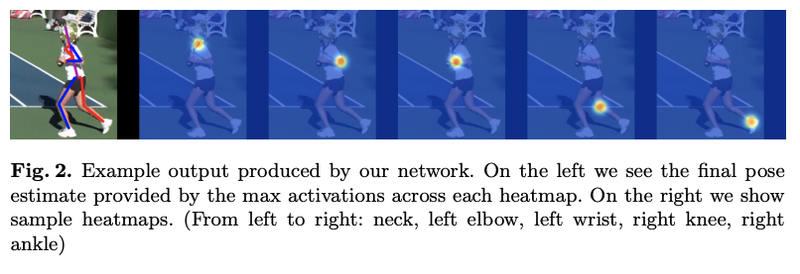

In [ ]:
def make_heatmaps(self, features, keypoint_x, keypoint_y):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * self.heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * self.heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = self.heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(self.heatmap_shape[1], self.heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

- 16개의 점을 generate_2d_gaussian() 함수를 이용해서 64x64 의 map 에 표현합니다.

2D 가우스 분포 수식을 적용해서 만들 수 있습니다.

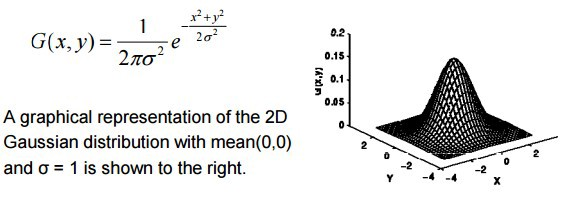

In [ ]:
def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        """
        "The same technique as Tompson et al. is used for supervision. A MeanSquared Error (MSE) loss is
        applied comparing the predicted heatmap to a ground-truth heatmap consisting of a 2D gaussian
        (with standard deviation of 1 px) centered on the keypoint location."

        https://github.com/princeton-vl/pose-hg-train/blob/master/src/util/img.lua#L204
        """
        heatmap = tf.zeros((height, width))

        # this gaussian patch is 7x7, let's get four corners of it first
        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma
        # if the patch is out of image boundary we simply return nothing according to the source code
        # [1]"In these cases the joint is either truncated or severely occluded, so for
        # supervision a ground truth heatmap of all zeros is provided."
        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        # the center of the gaussian patch should be 1
        center_x = size // 2
        center_y = size // 2

        # generate this 7x7 gaussian patch
        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        # part of the patch could be out of the boundary, so we need to determine the valid range
        # if xmin = -2, it means the 2 left-most columns are invalid, which is max(0, -(-2)) = 2
        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        # if xmin = 59, xmax = 66, but our output is 64x64, then we should discard 2 right-most columns
        # which is min(64, 66) - 59 = 5, and column 6 and 7 are discarded
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        # also, we need to determine where to put this patch in the whole heatmap
        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        # finally, insert this patch into the heatmap
        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap

sigma 값이 1 이고 window size 7 인 필터를 이용해서 만들었습니다.

이런 특수 함수들은 공개되어 있는 구현이 많기 때문에 참고해서 사용하는 것을 추천드립니다.

### preprocess.py

드디어 데이터 읽는 모듈이 다 완성되었습니다.

In [ ]:
import tensorflow as tf


class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y)

        # print (image.shape, heatmaps.shape, type(heatmaps))

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        """
        "The same technique as Tompson et al. is used for supervision. A MeanSquared Error (MSE) loss is
        applied comparing the predicted heatmap to a ground-truth heatmap consisting of a 2D gaussian
        (with standard deviation of 1 px) centered on the keypoint location."

        https://github.com/princeton-vl/pose-hg-train/blob/master/src/util/img.lua#L204
        """
        heatmap = tf.zeros((height, width))

        # this gaussian patch is 7x7, let's get four corners of it first
        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma
        # if the patch is out of image boundary we simply return nothing according to the source code
        # [1]"In these cases the joint is either truncated or severely occluded, so for
        # supervision a ground truth heatmap of all zeros is provided."
        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        # the center of the gaussian patch should be 1
        center_x = size // 2
        center_y = size // 2

        # generate this 7x7 gaussian patch
        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        # part of the patch could be out of the boundary, so we need to determine the valid range
        # if xmin = -2, it means the 2 left-most columns are invalid, which is max(0, -(-2)) = 2
        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        # if xmin = 59, xmax = 66, but our output is 64x64, then we should discard 2 right-most columns
        # which is min(64, 66) - 59 = 5, and column 6 and 7 are discarded
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        # also, we need to determine where to put this patch in the whole heatmap
        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        # finally, insert this patch into the heatmap
        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * self.heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * self.heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = self.heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(self.heatmap_shape[1], self.heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example_proto):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example_proto,
                                          image_feature_description)

# 16-6. 모델을 학습해보자

### Hourglass 모델 만들기
---
이번엔 `hourglass104.py` 라는 파일을 생성하겠습니다.

이 파일도 mpii.zip에 포함되어 있으므로 함께 확인해 주세요.

In [ ]:
import tensorflow as tf

from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization

이전 렉처 노드에서 소개했던 hourglass 모델, 잘 기억하고 계신가요?

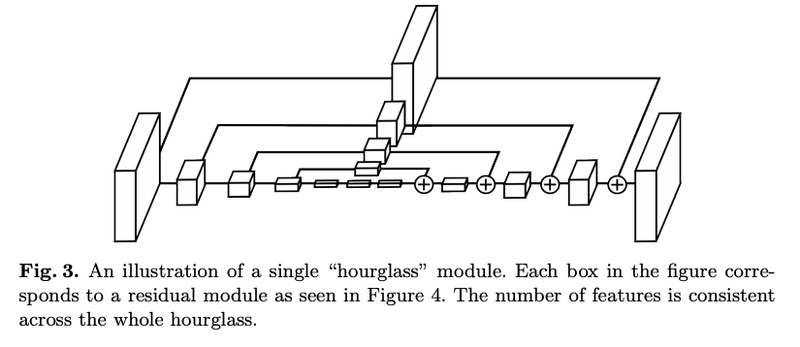

이렇게 생겼었죠! 직육면체 박스는 residual block 이었습니다. 하나씩 구현해 볼게요.

### Residual block module
---

In [ ]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,  # lift channels first
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x

resnet 구현과 비슷하기 때문에 이제는 정말 쉽게 느껴지는 코드입니다.

Q4. residual block 의 2가지 타입을 간단하게 작성해주세요. (N사 면접기출)

A4. 3x3-3x3 basic block, 1x1-3x3-1x1 bottleneck block

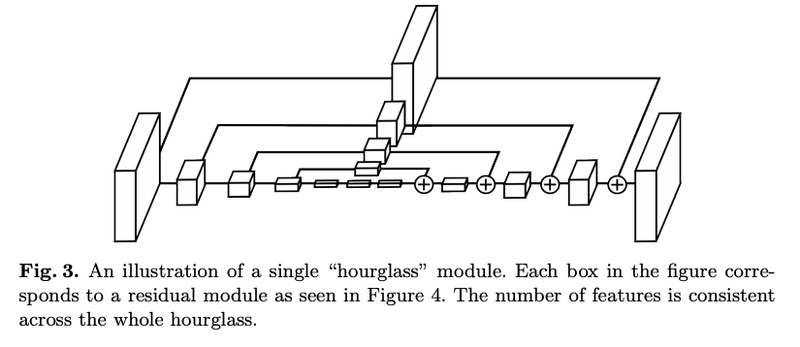

다시 돌아와서 hourglass 모델을 잘 생각해 보면 마치 양파처럼 가장 바깥의 layer 를 제거하면 똑같은 구조가 나타나는 것을 알 수 있습니다. 이 점을 이용해서 간단하게 모델을 표현할 수 있는데요.

### Hourglass module
---

In [ ]:
def HourglassModule(inputs, order, filters, num_residual):
    """
    https://github.com/princeton-vl/pose-hg-train/blob/master/src/models/hg.lua#L3
    """
    # Upper branch
    up1 = BottleneckBlock(inputs, filters, downsample=False)

    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    # Lower branch
    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

바로 재귀 함수를 이용하는 것이겠죠! 바깥부터 5개의 양파껍질(층)을 만들고 싶다면 order 를 이용해서 5,4...1 이 될 때까지 HourglassModule 을 반복하면 order 가 1이 되면 BottleneckBlock 으로 대체해 주면 아주 간결하게 만들 수 있습니다.

이 hourglass 모듈을 여러 층으로 쌓은 것이 stacked hourglass network 인데요, 모델이 깊어지는 만큼 학습이 어려워 intermediate loss (auxilary loss) 를 추가해야 하는 것을 논문에서 언급했습니다.

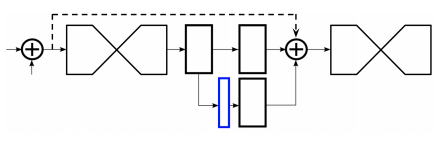

### intermediate output을 위한 linear layer
---

In [ ]:
def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x

따라서 stacked 되는 hourglass 층 사이사이에 LinearLayer 를 삽입하고 중간 loss 를 계산해 줍니다.

지금까지 만든 hourglass 를 여러 층으로 쌓으면 stacked hourglass 가 됩니다.

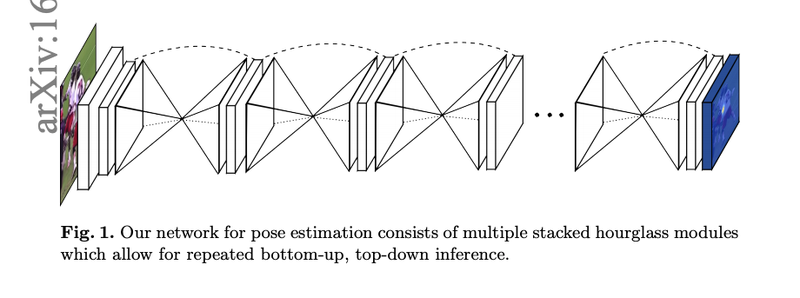

### Stacked Hourglass
---

In [ ]:
def StackedHourglassNetwork(
        input_shape=(256, 256, 3), num_stack=4, num_residual=1,
        num_heatmap=16):
    """
    https://github.com/princeton-vl/pose-hg-train/blob/master/src/models/hg.lua#L33
    """
    inputs = Input(shape=input_shape)

    # initial processing of the image
    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        # predict 256 channels like a fully connected layer.
        x = LinearLayer(x, 256)

        # predict final channels, which is also the number of predicted heatmap
        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        # if it's not the last stack, we need to add predictions back
        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

아래는 지금까지 작성해 온 내용을 정리한 `hourglass104.py` 파일입니다.

In [ ]:
import tensorflow as tf

from tensorflow.keras.layers import (
    Add,
    Concatenate,
    Conv2D,
    Input,
    Lambda,
    ReLU,
    MaxPool2D,
    UpSampling2D,
    ZeroPadding2D,
    BatchNormalization,
)

def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,  # lift channels first
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x


def HourglassModule(inputs, order, filters, num_residual):
    """
    https://github.com/princeton-vl/pose-hg-train/blob/master/src/models/hg.lua#L3
    """
    # Upper branch
    up1 = BottleneckBlock(inputs, filters, downsample=False)

    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    # Lower branch
    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1


def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x


def StackedHourglassNetwork(
        input_shape=(256, 256, 3), num_stack=4, num_residual=1,
        num_heatmap=16):
    """
    https://github.com/princeton-vl/pose-hg-train/blob/master/src/models/hg.lua#L33
    """
    inputs = Input(shape=input_shape)

    # initial processing of the image
    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        # predict 256 channels like a fully connected layer.
        x = LinearLayer(x, 256)

        # predict final channels, which is also the number of predicted heatmap
        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        # if it's not the last stack, we need to add predictions back
        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

# 16-7. 학습 엔진 만들기

학습 코드 train.py를 구현해 보겠습니다.

지금까지 제작한 *.py 모듈들은 여기서 참조(import)되어 사용될 것입니다.

이 파일도 mpii.zip에 포함되어 있으므로 함께 확인해 주세요.

In [ ]:
import math
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from datetime import datetime

import click
import tensorflow as tf

from hourglass104 import StackedHourglassNetwork
from preprocess import Preprocessor

IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

model 로 만들어 둔 hourglass와 데이터 전처리용 preprocess 를 import 합니다.

아래는 gpu memory growth 옵션을 조정하는 코드입니다.

In [ ]:
def automatic_gpu_usage() :
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

### Trainer class
---

In [ ]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate,
                 version='0.0.1',
                 start_epoch=1,
                 tensorboard_dir='./logs'):
        self.start_epoch = start_epoch
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)

        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.tensorboard_dir = tensorboard_dir
        self.best_model = None
        self.version = version

위 코드에서 정의한 학습에 사용할 옵션들 중 몇 가지를 눈여겨보아 둡시다.

- loss : MSE (heatmap 을 pixel 단위 MSE 로 계산) → 실제 계산은 약간 달라요! compute_loss() 에서 새로 구현합니다.
- strategy : 분산학습용 tf.strategy 입니다. 사용 가능한 GPU가 1개뿐이라면 사용하지 않아요.
- optimizer : Adam

### learning rate
---
learning rate 는 decay step 에 따라 1/10 씩 작아지도록 설정했습니다.

In [ ]:
    def lr_decay(self):
        """
        This effectively simulate ReduceOnPlateau learning rate schedule. Learning rate
        will be reduced by a factor of 5 if there's no improvement over [max_patience] epochs
        """
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

### loss function
---

In [ ]:
    def compute_loss(self, labels, outputs):
        loss = 0
        for output in outputs:
            # assign more weights to foreground pixels
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

이론대로라면 self.loss_object 를 사용해서 MSE 로 구현하는 것이 맞지만 사실 동일 weight MSE 는 수렴이 잘되지 않습니다. 예측해야 하는 positive (joint 들) 의 비율이 negative (배경이라고 할 수 있겠죠?) 에 비해 상당히 적은 비율로 등장하기 때문인데요. 이 때문에 실제 구현에서는 약간의 테크닉을 추가해 줄 필요가 있습니다. label 이 배경이 아닌 경우 (heatmap 값이 0보다 큰 경우) 에 추가적인 weight 를 주면 보다 나아지는 경향을 볼 수 있었습니다. weight 가 82인 이유는 heatmap 전체 크기인 64x64 에서 gaussian point 등장 비율이 7x7 패치이기 때문에 64 / 7 = 9.1 ⇒ 9x9 로 계산해 봤습니다.

tf.gradienttape 을 이용해 loss 를 업데이트하면 됩니다.

In [ ]:
    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

실제 학습하는 함수입니다.

distributed_train_epoch() 과 distributed_val_epoch() 함수는 gpu를 여러 개 이용하는 분산 학습용 코드이니, 사용하지 않더라도 참고삼아 봐두시길 권합니다.

In [ ]:
    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        summary_writer = tf.summary.create_file_writer(self.tensorboard_dir)
        summary_writer.set_as_default()

        for epoch in range(self.start_epoch, self.epochs + 1):
            tf.summary.experimental.set_step(epoch)

            self.lr_decay()
            tf.summary.scalar('epoch learning rate',
                              self.current_learning_rate)

            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))
            tf.summary.scalar('epoch train loss', train_loss)

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))
            tf.summary.scalar('epoch val loss', val_loss)

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

In [ ]:
def save_model(self, epoch, loss):
        model_name = './models/model-v{}-epoch-{}-loss-{:.4f}.h5'.format(
            self.version, epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

### tf.dataset 만들기

trainer 의 모델 학습 부분은 제작이 완료되었고 tfrecord 파일을 tf.dataset 으로 만들어 보겠습니다.

In [ ]:
def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

preprocessor 구현에서 tfrecord 규칙을 모두 정의했기 때문에 단순히 tfrecord list 을 읽어와서 tf.data API 에 입력한 후, preprocessor 를 map 으로 적용하면 됩니다.

### train함수 구현
---

In [ ]:
def train(epochs, start_epoch, learning_rate, tensorboard_dir, checkpoint,
          num_heatmap, batch_size, train_tfrecords, val_tfrecords, version):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(os.path.join('./models')):
        os.makedirs(os.path.join('./models/'))

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)
        if checkpoint and os.path.exists(checkpoint):
            model.load_weights(checkpoint)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate,
            start_epoch=start_epoch,
            version=version,
            tensorboard_dir=tensorboard_dir)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

아래는 train.py의 메인 실행부입니다.

In [ ]:
if __name__ == "__main__":
    tfrecords_dir = './dataset/tfrecords_mpii/'
    train_tfrecords = os.path.join(tfrecords_dir, 'train*')
    val_tfrecords = os.path.join(tfrecords_dir, 'val*')
    epochs = 2
    batch_size = 16
    num_heatmap = 16
    tensorboard_dir = './logs/'
    learning_rate = 0.0007
    start_epoch = 1

    automatic_gpu_usage()
    
    pretrained_path = None

    train(epochs, start_epoch, learning_rate, tensorboard_dir, pretrained_path,
          num_heatmap, batch_size, train_tfrecords, val_tfrecords, '0.0.1')

### train.py
---
학습해 봅시다.

> (주의) 1Epoch 에 30분 이상 소요될 수 있습니다. 아래 코드는 2Epoch 학습으로 구현되어 있지만 실제 코드 실행 시에는 Epoch 수 등을 적절히 조절해 주시기 바랍니다.

In [ ]:
!cd ~/aiffel/mpii && python train.py